In [1]:
!cat ../README.md

# Super Resolution, On The Edge, For The Win!
*by Akshay Chawla and Priyam Tejaswin*

Main reference paper : [Real-Time Video Super-Resolution with Spatio-Temporal Networks and Motion Compensation, CVPR 2017](http://openaccess.thecvf.com/content_cvpr_2017/papers/Caballero_Real-Time_Video_Super-Resolution_CVPR_2017_paper.pdf)
```
.
├── README.md
├── papers ## PDFs for review and reference (not committed).
├── src_tensorflow ## Code in tf (using `tensorflow.keras`). 
└── src_tf2 ## Code in tf2_alpha.
```

## Dependencies
- `src_tensorflow` uses **tensorflow 1.13.1**. This is the latest stable release as of creating this repository.
- `src_tf2` uses **tensorflow 2.0** which is still an alpha build.

## System Design
![](system_blocks.jpg)

## References
- VESPCN implementation (unofficial, TF) - <https://github.com/LoSealL/VideoSuperResolution/blob/master/VSR/Models/Vespcn.py>
- Fully-featured TF2 implementation of YOLOv3 (for checking TF2 oddities) - <https://github.com/zzh8829/yolov3-tf

In [2]:
import tensorflow as tf

In [3]:
tf.enable_eager_execution()
print tf.executing_eagerly()

True


In [368]:
dataset = tf.data.TextLineDataset("../README.md")
dataset = dataset.map(lambda line: tf.string_split([line]).values)
dataset = dataset.filter(lambda row: tf.size(row) > 3)
dataset = dataset.map(lambda row: tf.slice(row, [0], [2]))
dataset = dataset.window(size=3, stride=1, drop_remainder=True) ## THIS WILL RETURN A DATASET!!!!
dataset = dataset.flat_map(lambda dset: dset.batch(3))
# How to shuffle?

In [369]:
for i in range(5):
    for batch in dataset:
        print i, batch

0 tf.Tensor(
[['#' 'Super']
 ['*by' 'Akshay']
 ['Main' 'reference']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80' 'papers']
 ['\xe2\x94\x9c\xe2\x94\x80\xe2\x94\x80' 'src_tensorflow']
 ['\xe2\x94\x94\xe2\x94\x80\xe2\x94\x80' 'src_tf2']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['-' '`src_tensorflow`']
 ['-' '`src_tf2`']
 ['Training' 'data']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['Lo' 'and']
 ['The' 'catch?']
 ['By' 'default,']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['While'
  '[tf.image.extract_image_patches](https://www.tensorflow.org/api_docs/python/tf/image/extract_image_patches)']
 ['Consider' 'the']
 ['To' 'visualise']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['Below' 'we']
 ['>>>' 'img']
 ['>>>' 'print']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['[[' '0']
 ['[12' '14']
 ['[24' '26']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['[36' '38']
 ['[48' '50']
 ['[60' '62']], shape=(3, 2), dtype=string)
0 tf.Tensor(
[['>>>' 'print']

4 tf.Tensor(
[['(1,' '2,']
 ['-' 'Our']
 ['-' 'Height']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['-' 'The']
 ['[[' '0']
 ['[12' '14']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[24' '26']
 ['[36' '38']
 ['-' 'Where']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[["Here's" 'how']
 ['-' 'Given']
 ['-' 'The']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[["Let's" 'look']
 ['>>>' 'print']
 ['[' '0']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['36' '37']
 ['This' 'has']
 ['How' 'about']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['>>>' 'print']
 ['Ah,' 'now,']
 ['>>>' 'print']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[[' '0']
 ['[12' '14']
 ['[24' '26']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[36' '38']
 ['>>>' 'print']
 ['[[' '1']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['[13' '15']
 ['[25' '27']
 ['[37' '39']], shape=(3, 2), dtype=string)
4 tf.Tensor(
[['And' 'voila!']
 ['-' 'VESPCN']
 ['-' 'Fully-featured']], shape=(3, 2), dtype=string)


In [91]:
!pwd

/Users/tejaswin.p/THIS_LAPTOP_projects/srote-ftw/src_tensorflow


In [93]:
!ls

dump_frames.py rough.ipynb


In [95]:
os.path.isdir('helloworld')

False

In [96]:
os.listdir('.')

['rough.ipynb', 'dump_frames.py', '.ipynb_checkpoints']

## Loading frames.

In [267]:
import os
import itertools

VFDEL = '___' ## VideoName___FrameId delimiter.
NFRAMES = 2 ## Number of frames considered per sample.

def _fskey(f):
    vname, fid = f.rstrip('.png').split(VFDEL)
    fid = int(fid)
    return vname, fid

def build_dataset(fdir):
    all_frames = []

    vdirs = [os.path.join(fdir, d) for d in os.listdir(fdir)]
    vdirs = [d for d in vdirs if os.path.isdir(d)]
    print "Found %d vid files."%len(vdirs)

    for dpath in vdirs:
        print "In %s"%dpath
        frames = [f for f in os.listdir(dpath) if f.endswith('.png')]
        print "\tFound %d frames."%len(frames)

        frames = sorted(frames, key=lambda x:_fskey(x))
        frames = [os.path.join(dpath, f) for f in frames]

        ## Group sorted frames by NFRAMES.
        motion_frames = []
        for i in range(len(frames) - NFRAMES + 1):
            motion_frames.append(tuple(frames[i : i+NFRAMES]))

        ## Add to master list.
        all_frames.extend(motion_frames)

    print "Found %d frame groups of length %d."%(len(all_frames), NFRAMES)
    return all_frames

In [448]:
batched_fnames = build_dataset('../data/frames/')
batched_fnames[:2]

Found 2 vid files.
In ../data/frames/hall_monitor_cif.y4m
	Found 300 frames.
In ../data/frames/sample_hd_video.mp4
	Found 376 frames.
Found 674 frame groups of length 2.


[('../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___1.png',
  '../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___2.png'),
 ('../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___2.png',
  '../data/frames/hall_monitor_cif.y4m/hall_monitor_cif.y4m___3.png')]

In [449]:
## Using tensor_slices...
dataset = tf.data.Dataset.from_tensor_slices(batched_fnames[:2]) ## Paired frames.
dataset = dataset.shuffle(buffer_size=len(batched_fnames)) ## Paired frames are shuffled.

dataset = dataset.flat_map(tf.data.Dataset.from_tensor_slices) ## Flatten | Order will be preserved | https://stackoverflow.com/questions/51015918
dataset = dataset.map(load_image) ## Single frame images loaded.

dataset = dataset.window(size=NFRAMES, drop_remainder=True) ## Window consecutive frames.
dataset = dataset.flat_map(lambda dset: dset.batch(NFRAMES)) ## Group the frames | Loaded frames are paired again.

dataset = dataset.map(make_patches) ## Generate patches for paired frames AND swap axes : [patches, NFRAMES, k, k, c]

dataset = dataset.flat_map(tf.data.Dataset.from_tensor_slices) ## Flatten | single tensors of [NFRAMES, k, k, c]

dataset = dataset.shuffle(buffer_size=256) ## After single tensors and BEFORE (x,y) generation. 

dataset = dataset.map(make_xy) ## Return (X,Y): (Downscaled, Original) 

dataset = dataset.batch(64) ## Final batching.

for row in dataset: ## Tuple (x,y) of [batch, NFRAME, k, k, c]
    ## After shuffling, patches should be non-consecutive, though they might be from the same picture.
    print row[0].shape, row[1].shape

(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(64, 2, 48, 48, 3) (64, 2, 96, 96, 3)
(20, 2, 48, 48, 3) (20, 2, 96, 96, 3)


In [258]:
a = np.arange(48).reshape([3, 4, 4])
b = np.arange(48, 96).reshape([3, 4, 4])
print a
print "-"*50
print b

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]
  [12 13 14 15]]

 [[16 17 18 19]
  [20 21 22 23]
  [24 25 26 27]
  [28 29 30 31]]

 [[32 33 34 35]
  [36 37 38 39]
  [40 41 42 43]
  [44 45 46 47]]]
--------------------------------------------------
[[[48 49 50 51]
  [52 53 54 55]
  [56 57 58 59]
  [60 61 62 63]]

 [[64 65 66 67]
  [68 69 70 71]
  [72 73 74 75]
  [76 77 78 79]]

 [[80 81 82 83]
  [84 85 86 87]
  [88 89 90 91]
  [92 93 94 95]]]


In [436]:
def load_image(fpath):
    """
    Load and 'snap' to compatible size (extract 96x96 grids).
    """
    image_string = tf.read_file(fpath)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image

In [446]:
def make_patches(image):
    KERNEL = 96
    STRIDE = 14
    
    channels = tf.shape(image)[-1]
    patches = tf.image.extract_image_patches(
        image,
        ksizes = [1, KERNEL, KERNEL, 1],
        strides = [1, STRIDE, STRIDE, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    patches = tf.squeeze(patches)
    
    shape = tf.shape(patches) ## [frames, patches_x, patches_y, `channels`]
    
    patches = tf.reshape(patches, [NFRAMES, shape[1], shape[2], KERNEL, KERNEL, channels])
    patches = tf.reshape(patches, [NFRAMES, shape[1] * shape[2], KERNEL, KERNEL, channels])
    
    patches = tf.transpose(patches, [1, 0, 2, 3, 4])
    return patches

In [447]:
def make_xy(patches):
    DOWNK = 48
    downed = tf.image.resize_images(patches, [DOWNK, DOWNK])
    
    return downed, patches

In [439]:
a = np.arange(96).reshape([2, 3, 4, 4])
at = tf.constant(a)
print at

tf.Tensor(
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]

  [[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]

  [[32 33 34 35]
   [36 37 38 39]
   [40 41 42 43]
   [44 45 46 47]]]


 [[[48 49 50 51]
   [52 53 54 55]
   [56 57 58 59]
   [60 61 62 63]]

  [[64 65 66 67]
   [68 69 70 71]
   [72 73 74 75]
   [76 77 78 79]]

  [[80 81 82 83]
   [84 85 86 87]
   [88 89 90 91]
   [92 93 94 95]]]], shape=(2, 3, 4, 4), dtype=int64)


In [440]:
print tf.transpose(at, [1, 0, 2, 3])

tf.Tensor(
[[[[ 0  1  2  3]
   [ 4  5  6  7]
   [ 8  9 10 11]
   [12 13 14 15]]

  [[48 49 50 51]
   [52 53 54 55]
   [56 57 58 59]
   [60 61 62 63]]]


 [[[16 17 18 19]
   [20 21 22 23]
   [24 25 26 27]
   [28 29 30 31]]

  [[64 65 66 67]
   [68 69 70 71]
   [72 73 74 75]
   [76 77 78 79]]]


 [[[32 33 34 35]
   [36 37 38 39]
   [40 41 42 43]
   [44 45 46 47]]

  [[80 81 82 83]
   [84 85 86 87]
   [88 89 90 91]
   [92 93 94 95]]]], shape=(3, 2, 4, 4), dtype=int64)


In [240]:
img_str = tf.read_file('/Users/tejaswin.p/Desktop/fk_iphone_lol.png')
img = tf.image.decode_png(img_str, channels=3)
img = tf.expand_dims(img, 0)

smaller = tf.image.resize_bilinear(img, [600, 1000], align_corners=False)

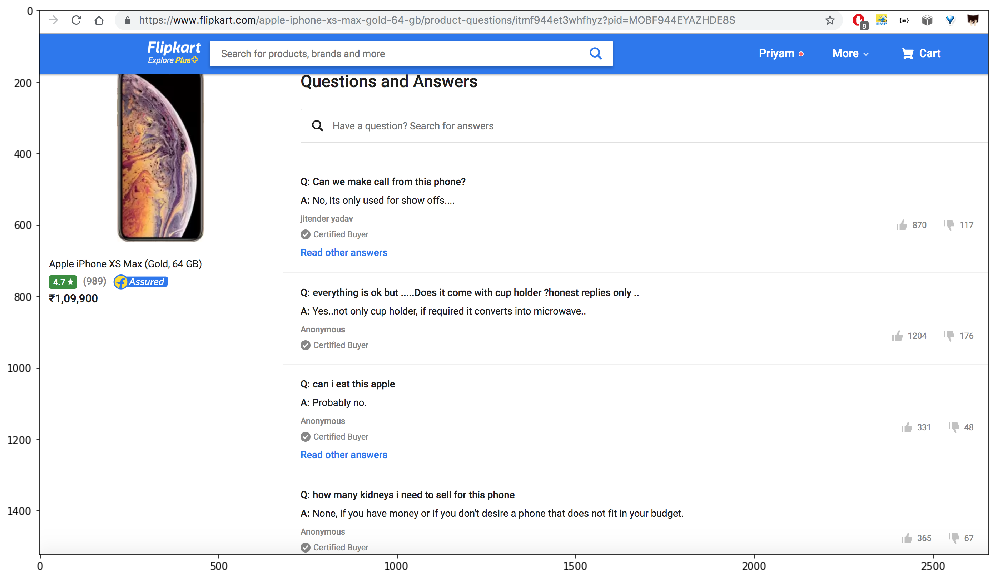

In [241]:
plt.figure(figsize=(20, 10))
plt.imshow(img.numpy()[0]);

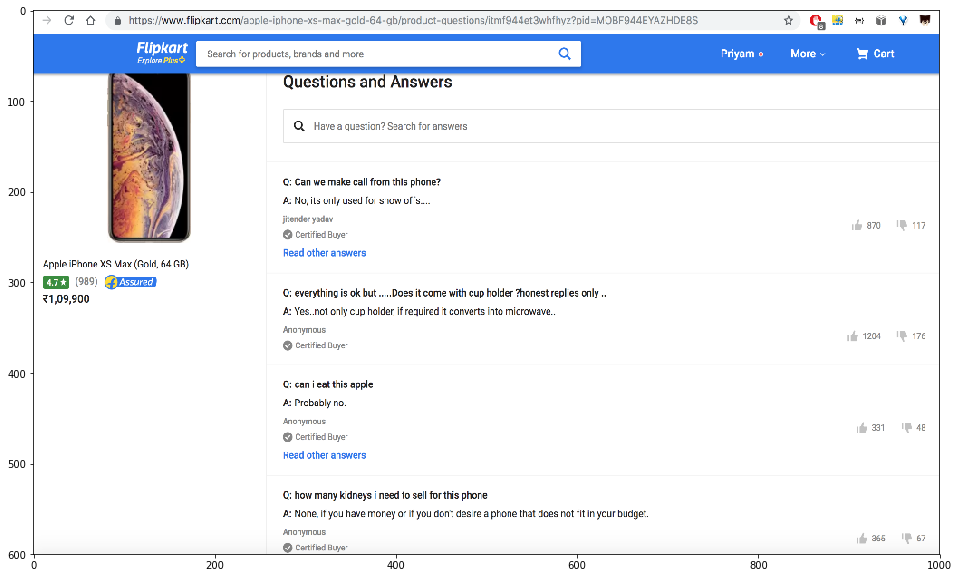

In [242]:
plt.figure(figsize=(20, 10))
plt.imshow(smaller.numpy()[0].astype(np.uint8));